In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

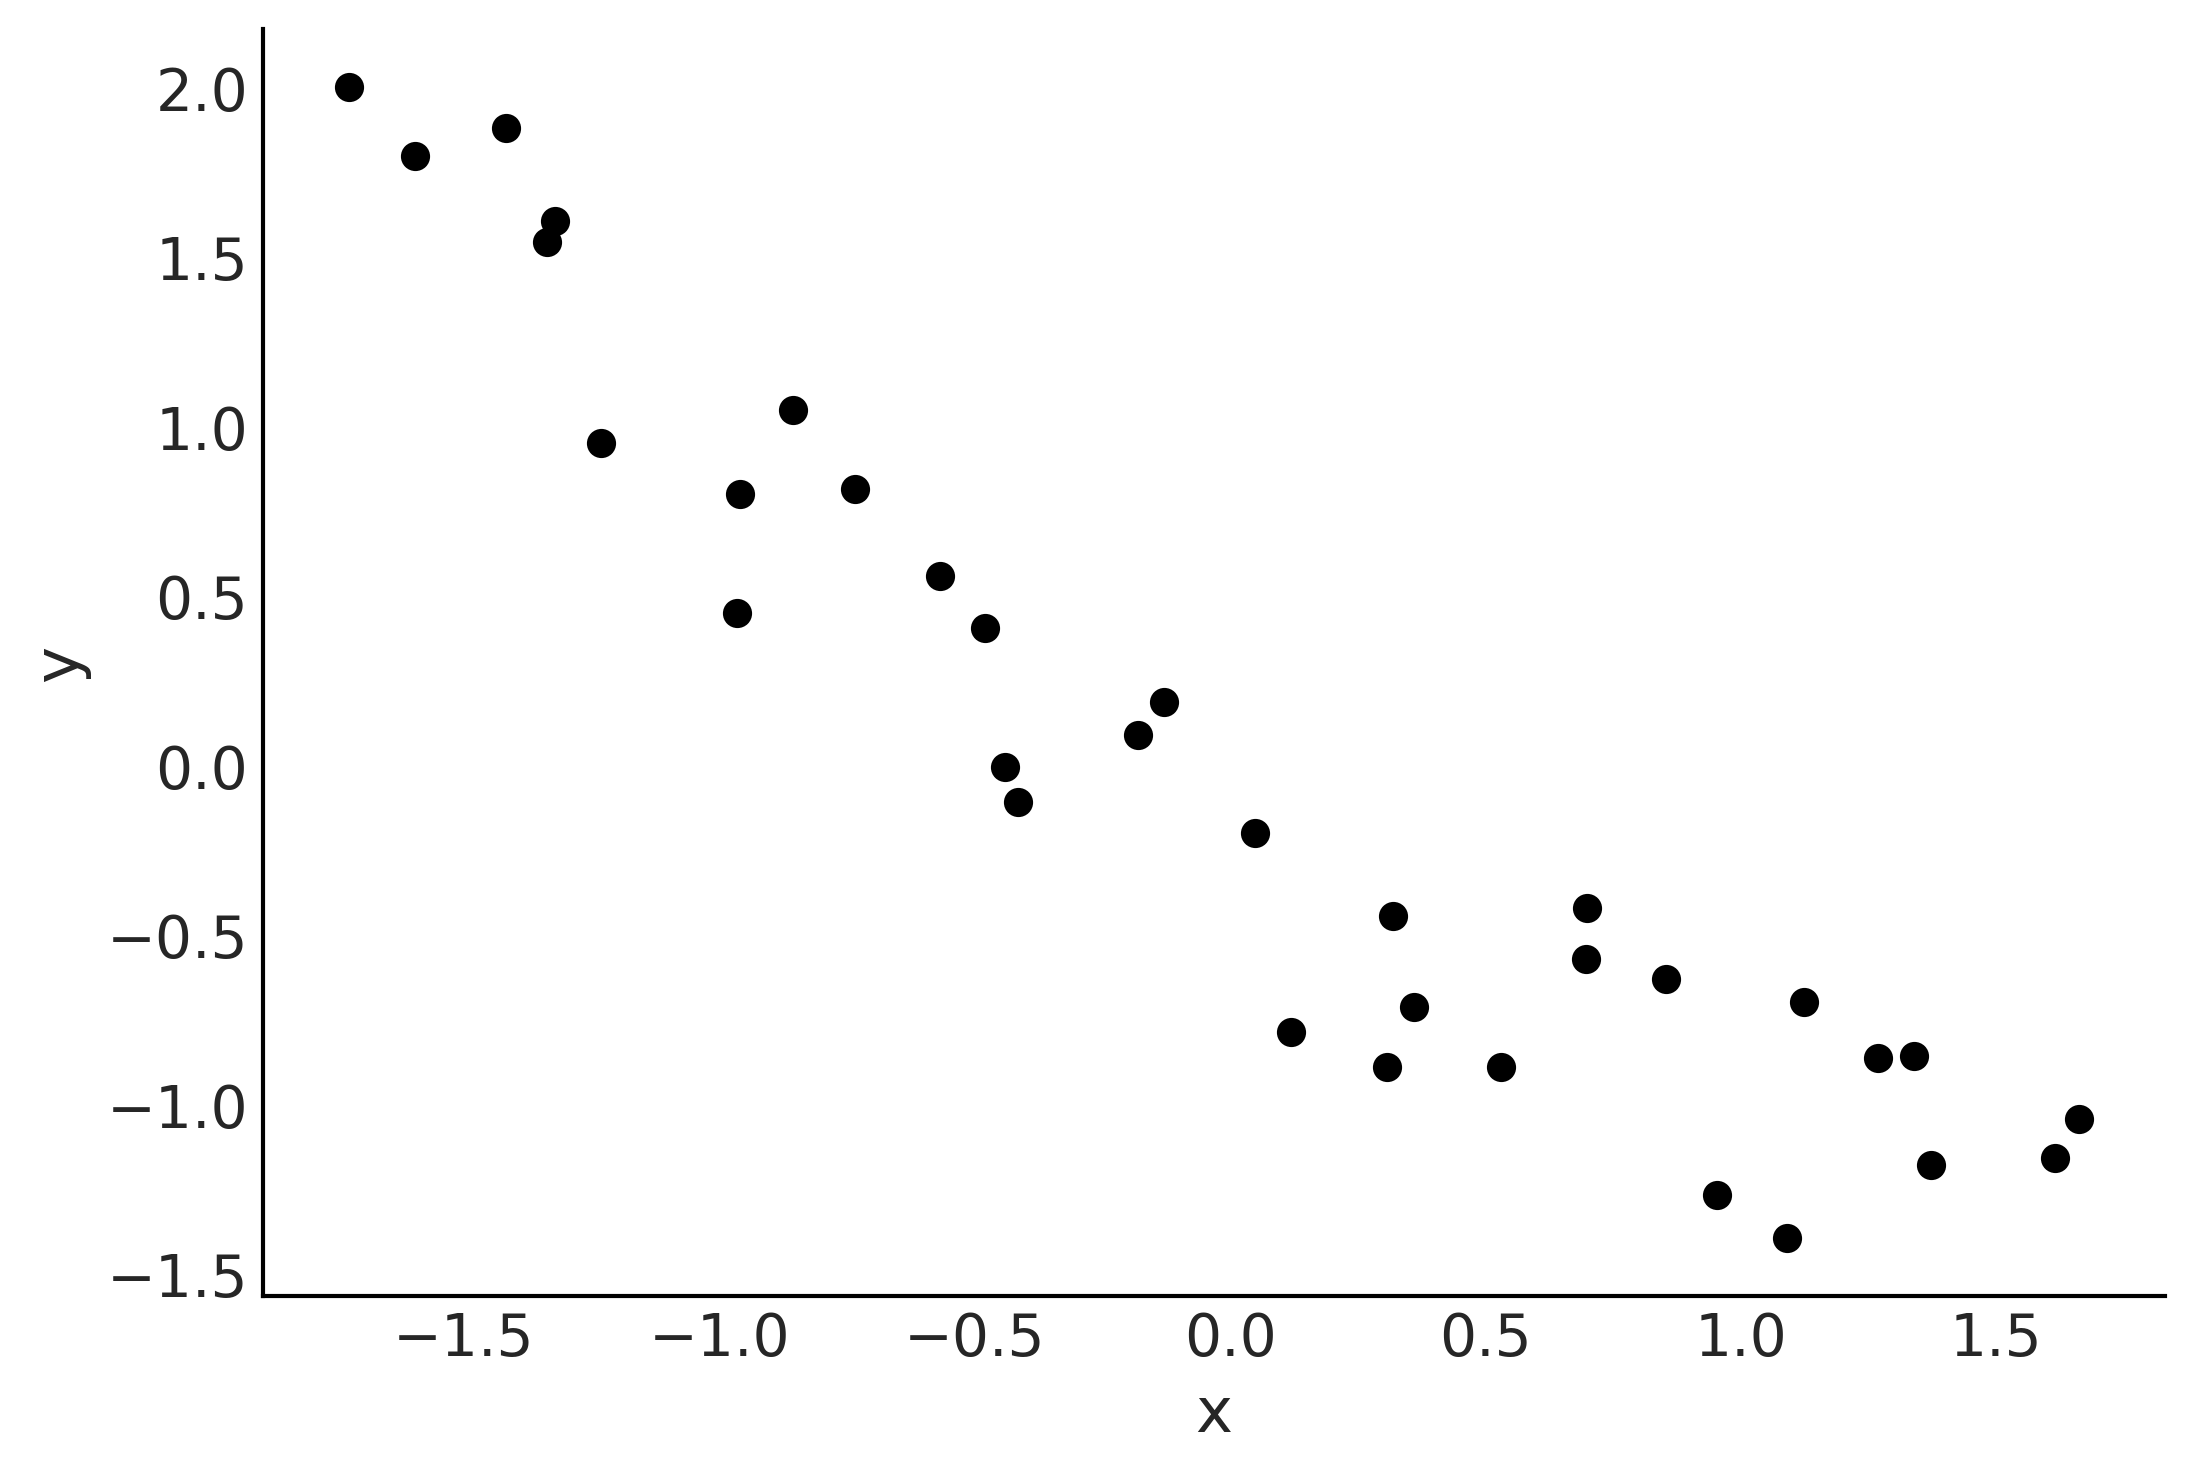

In [3]:
dummy_data = np.loadtxt('data/dummy.csv')
x = dummy_data[:,0]
y = dummy_data[:,1]

order = 2
x_p = np.vstack([x**i for i in range(1, order+1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y');

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfNormal('σ', 5)

    μ = α + β * x_c[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))

with pm.Model() as model_q:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10, shape=order)
    σ = pm.HalfNormal('σ', 5)

    μ = α + pm.math.dot(β, x_c)
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_pred]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
Sampling: [y_pred]


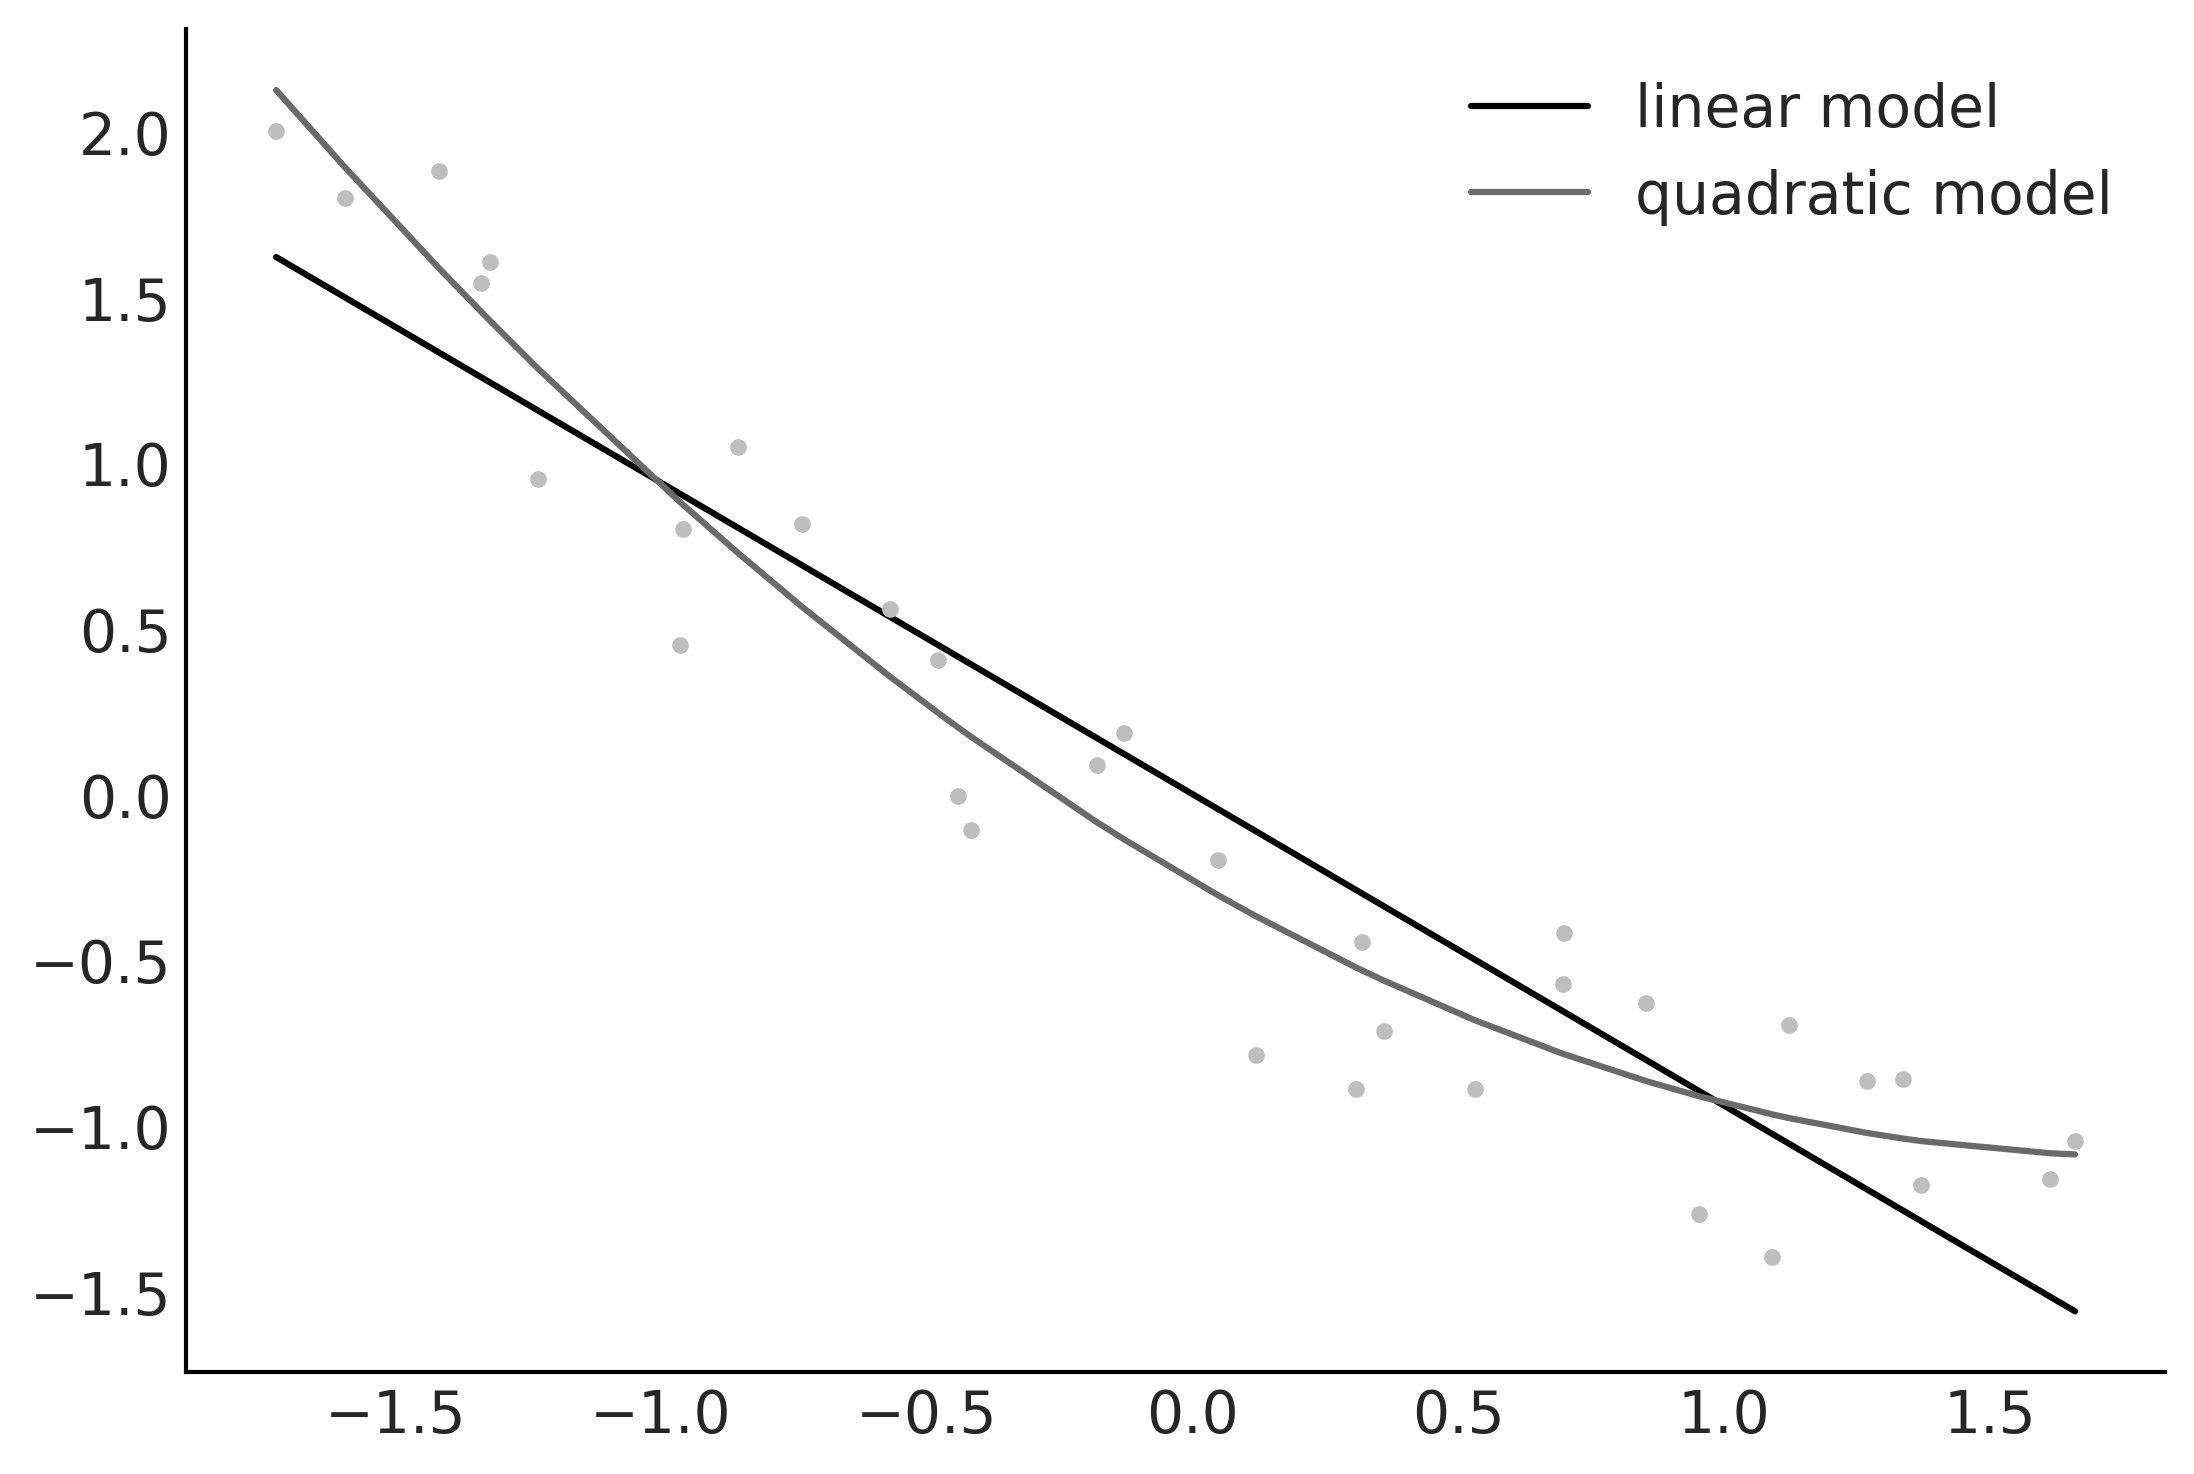

In [5]:
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_q)

α_l_post = posterior_l['α'].mean().item()
β_l_post = posterior_l['β'].mean().item()
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C0', label='linear model')

α_p_post = posterior_p['α'].mean().item()
β_p_post = posterior_p['β'].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], 'C1', label=f'quadratic model')

plt.plot(x_c[0], y_c, "C2.")
plt.legend()
plt.savefig("../fig/lin-pol-fit.png")

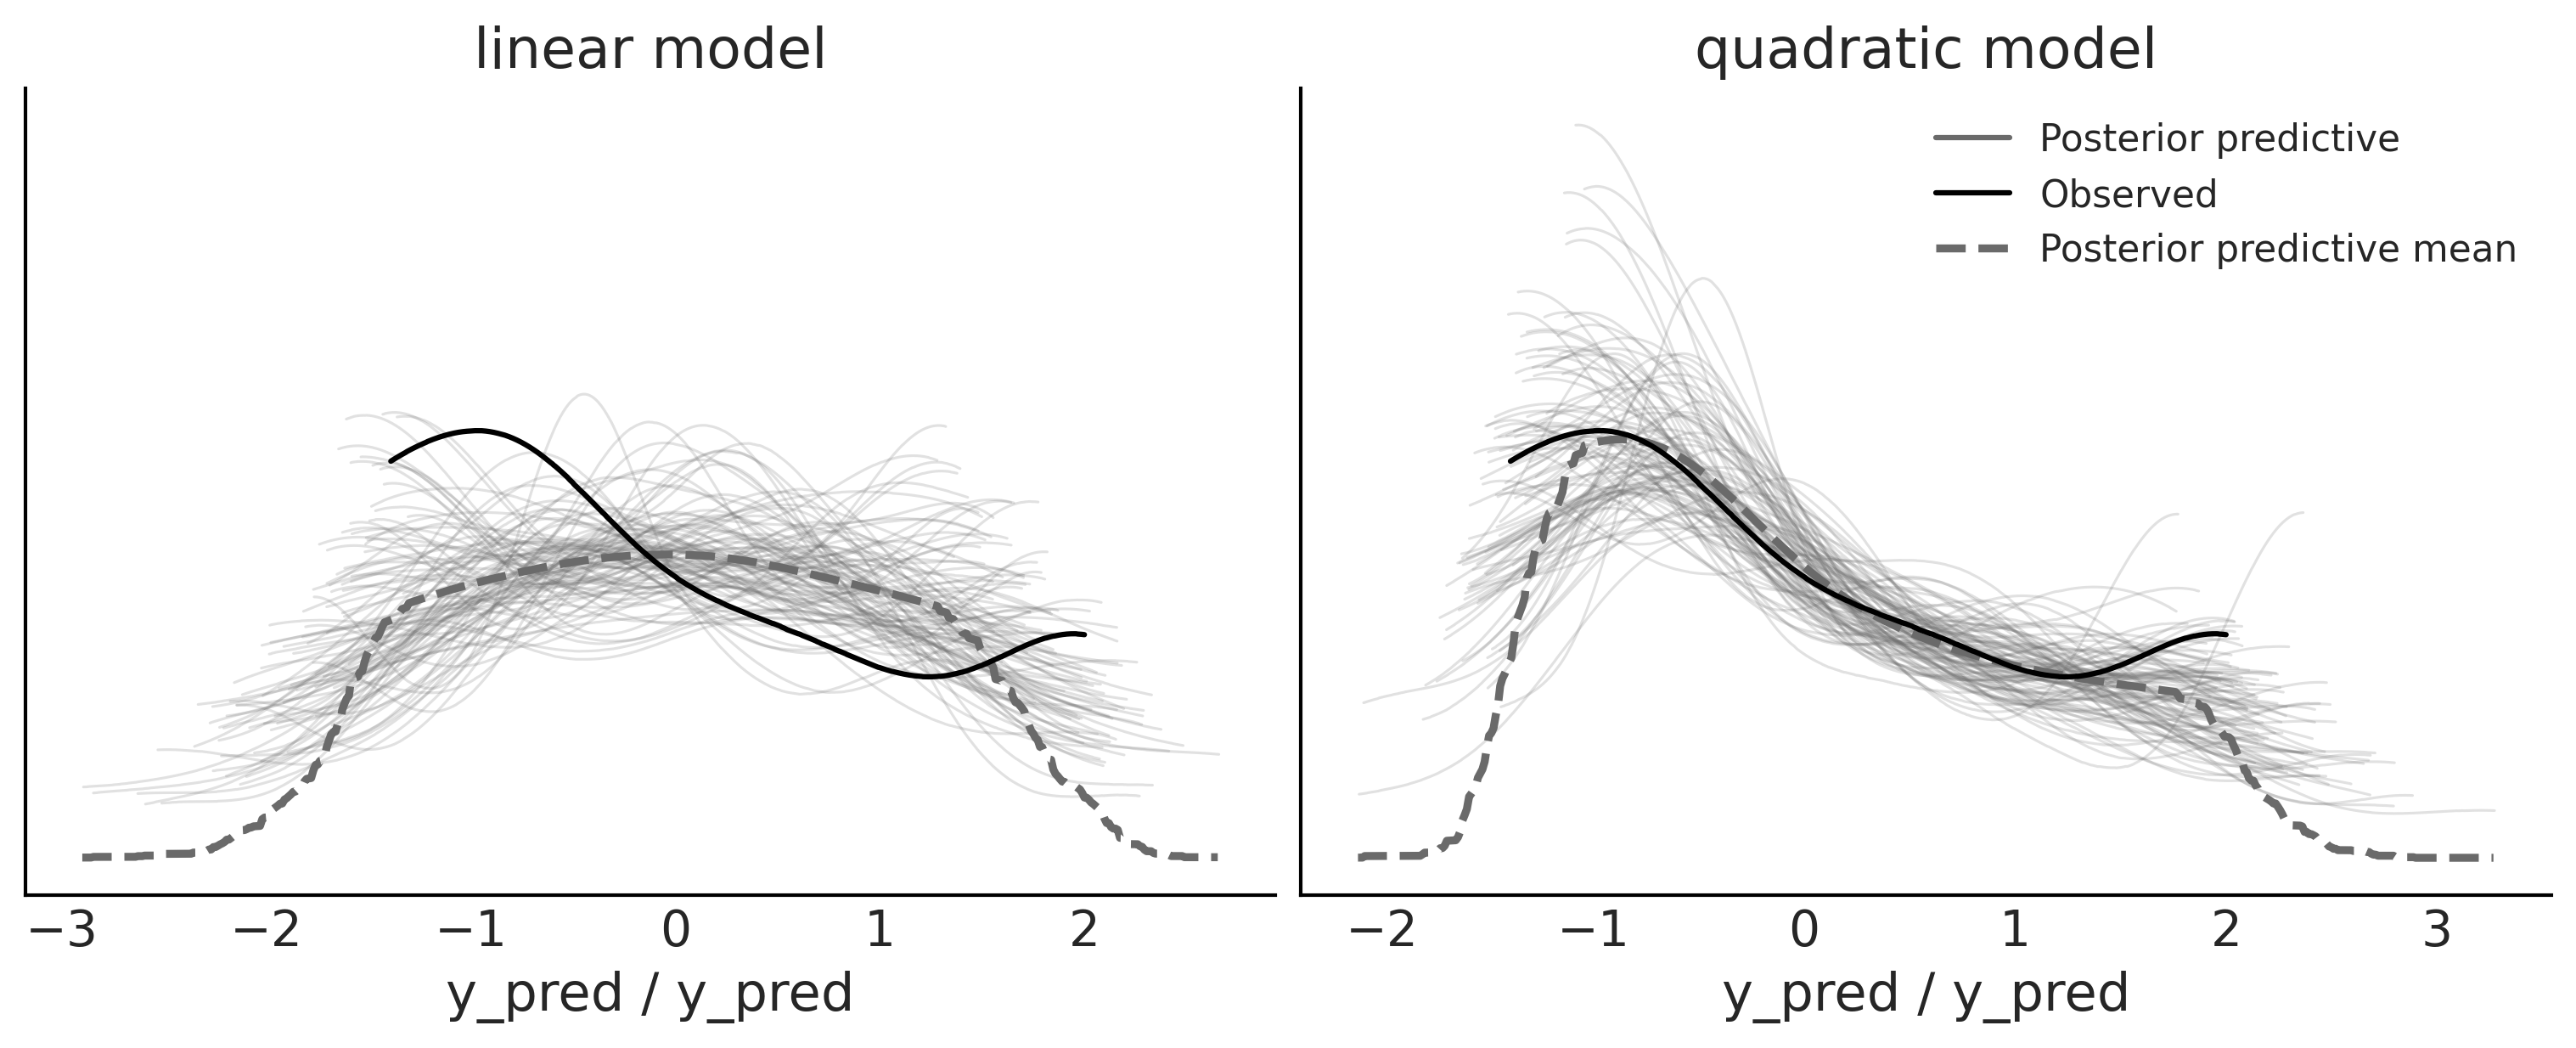

In [11]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title('linear model')
az.plot_ppc(idata_q, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f'quadratic model')

plt.savefig("../fig/lin-pol-ppc.png")

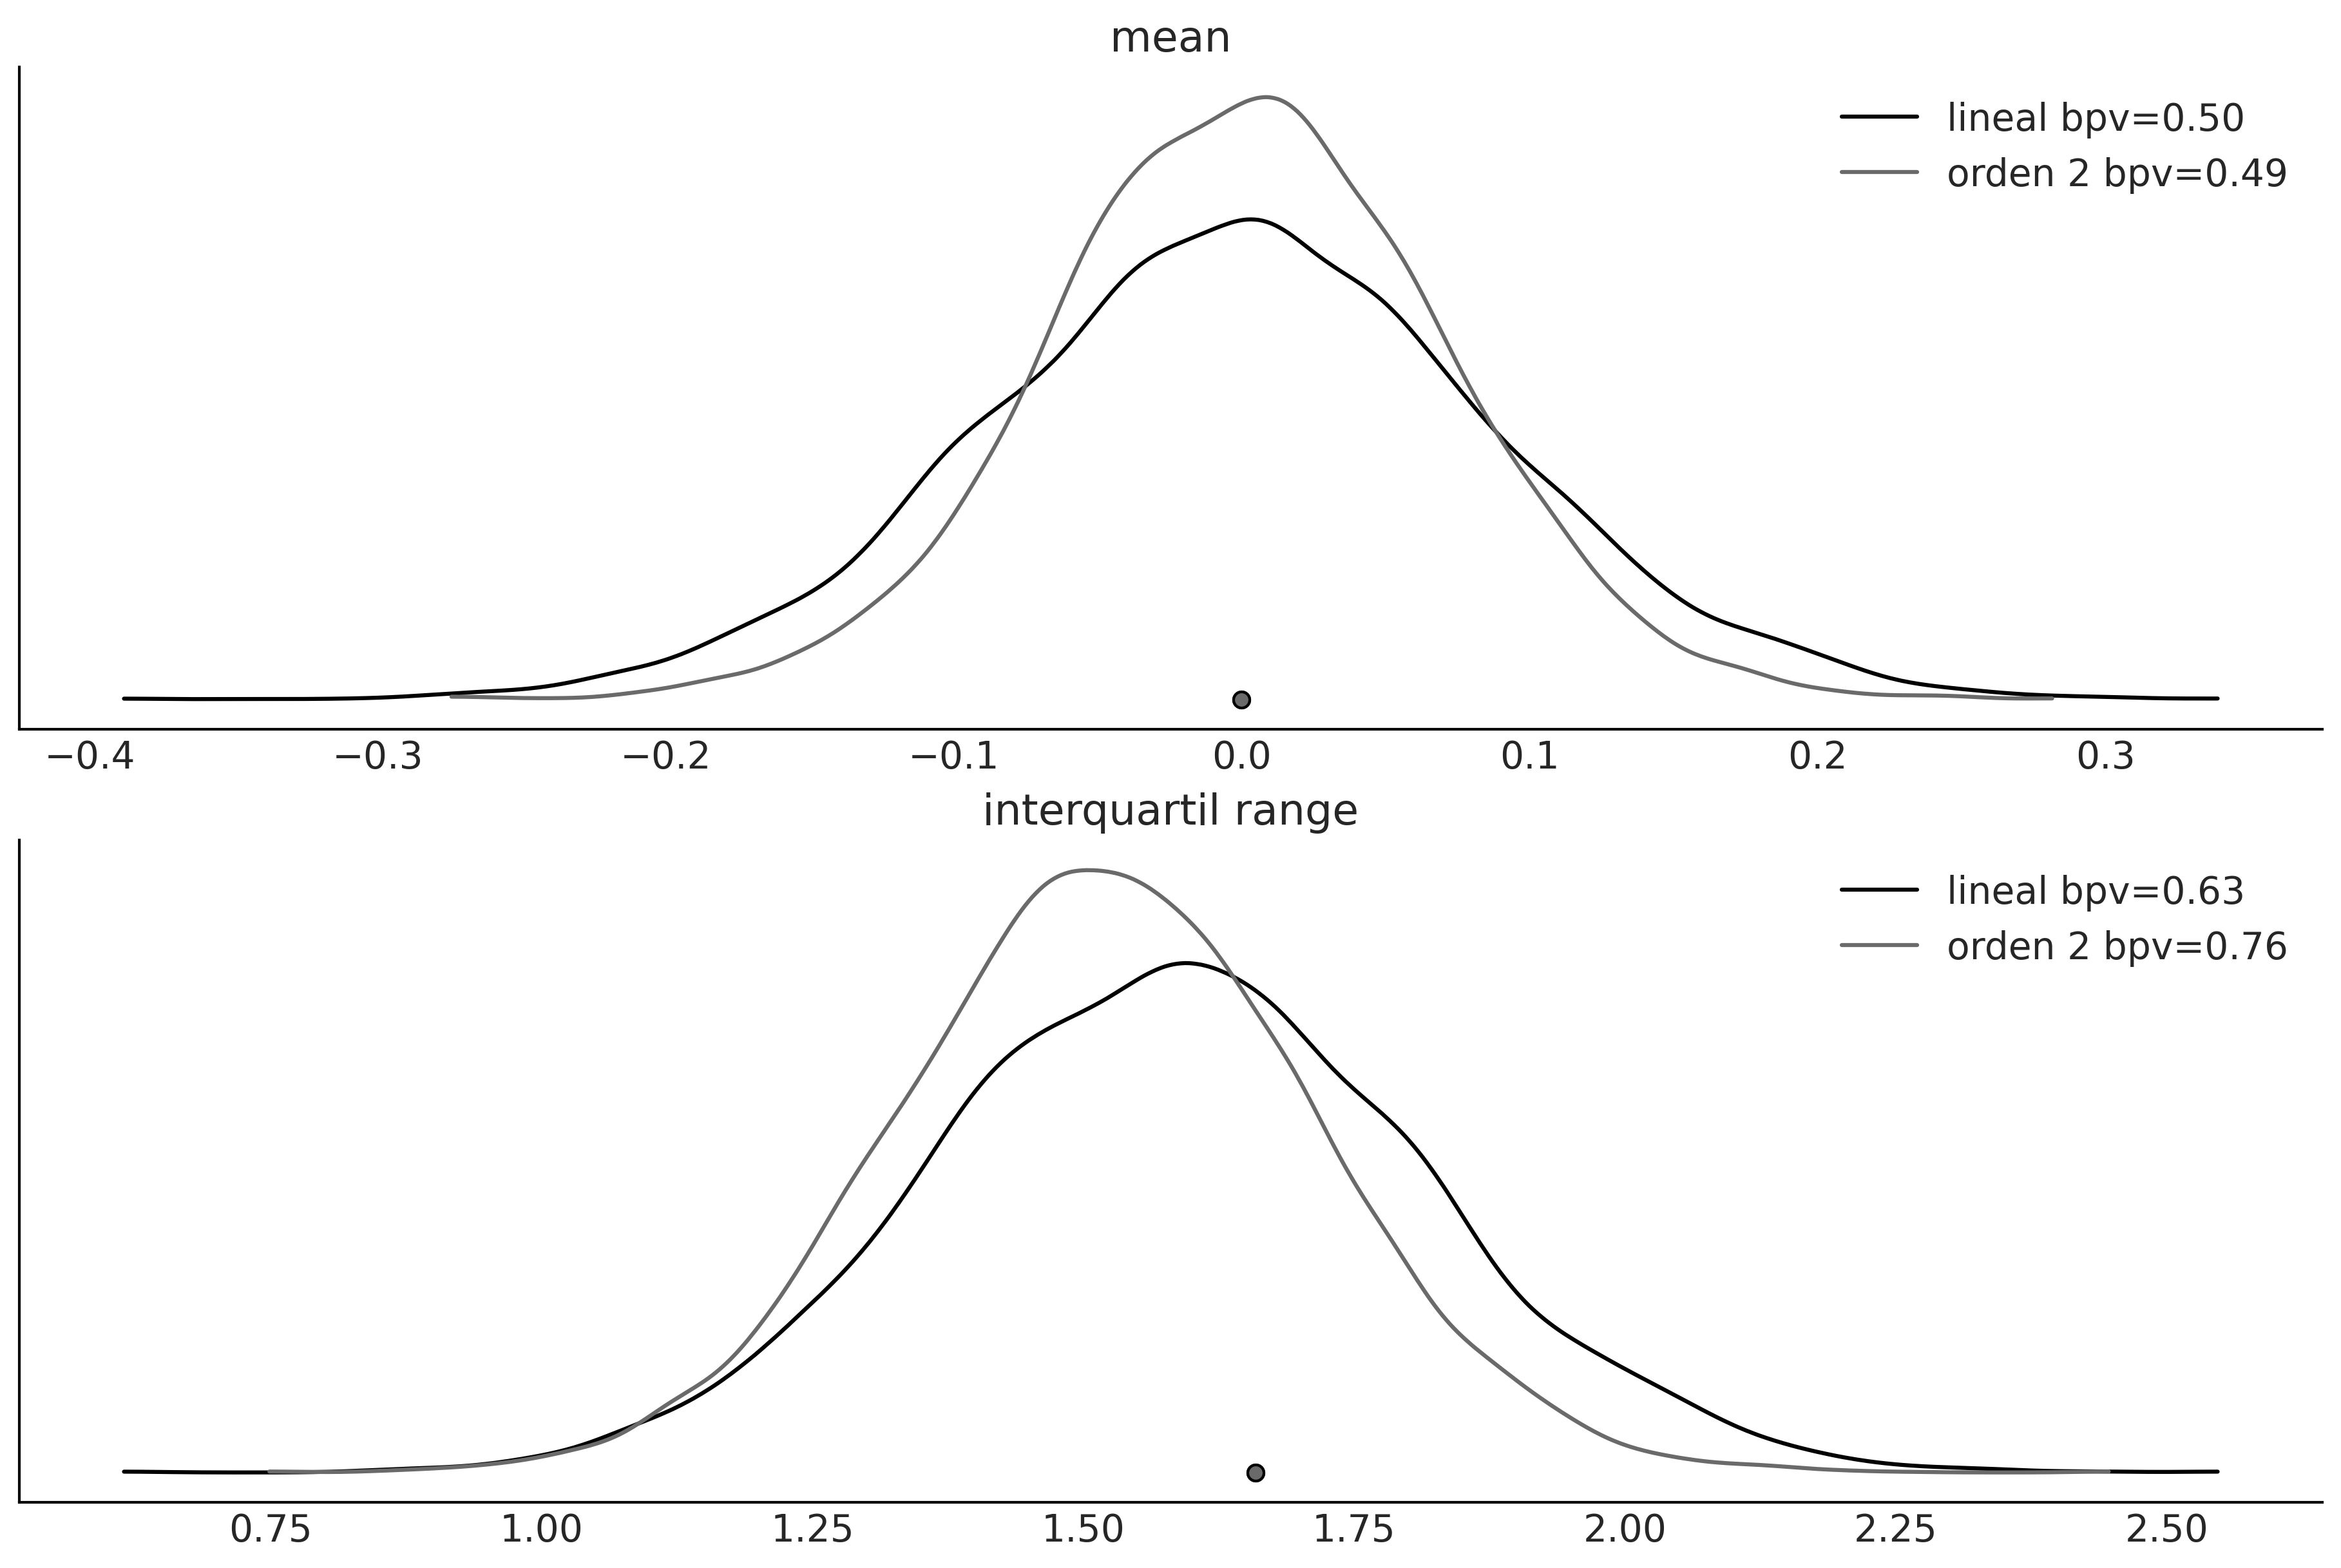

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["mean", "interquartil range"]
modelos = ["lineal", f'orden {order}']
idatas = [idata_l, idata_q]

def iqr(x, a=-1):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)
    

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for ax, title, in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles [idx]._alpha = 1
        ax.legend_.legend_handles [idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

plt.savefig("../fig/lin-pol-bpv.png")

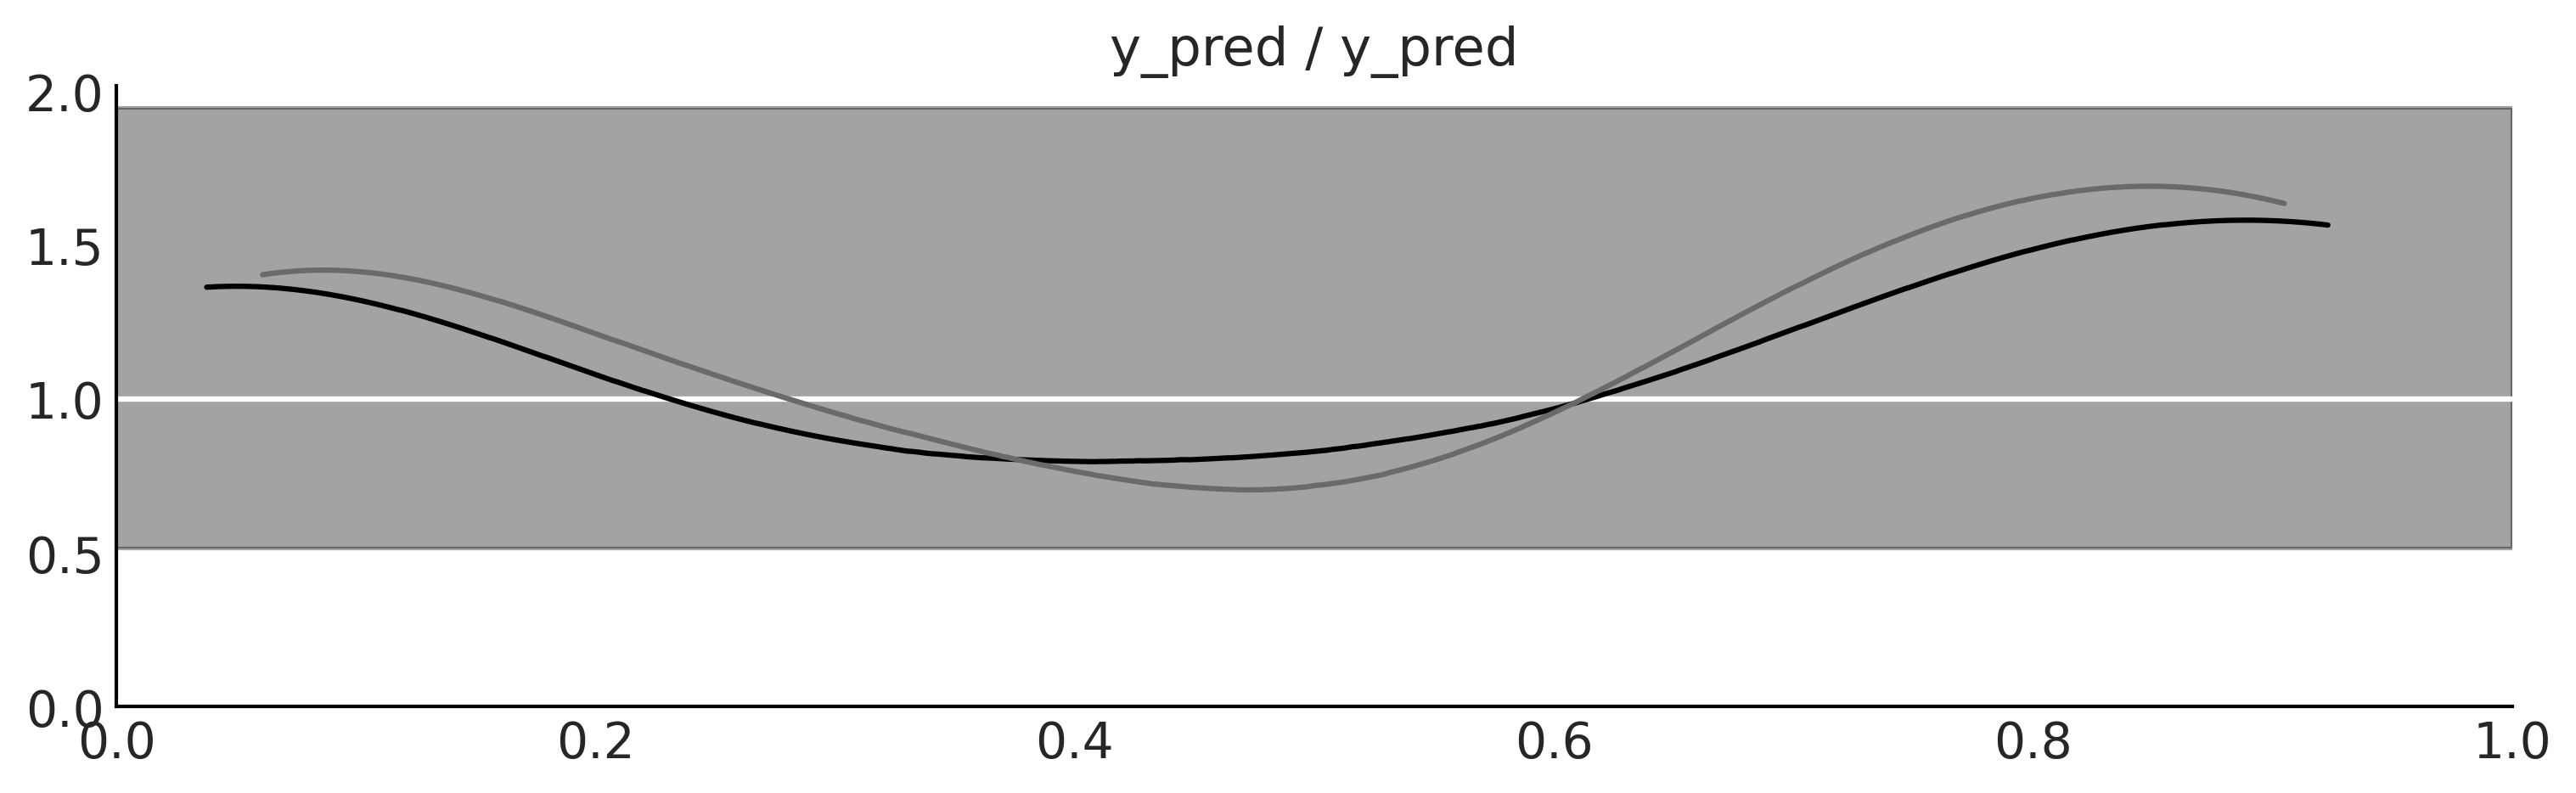

In [12]:
fig, ax = plt.subplots(figsize=(10, 3))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

plt.savefig("../fig/lin-pol-bpv2.png")

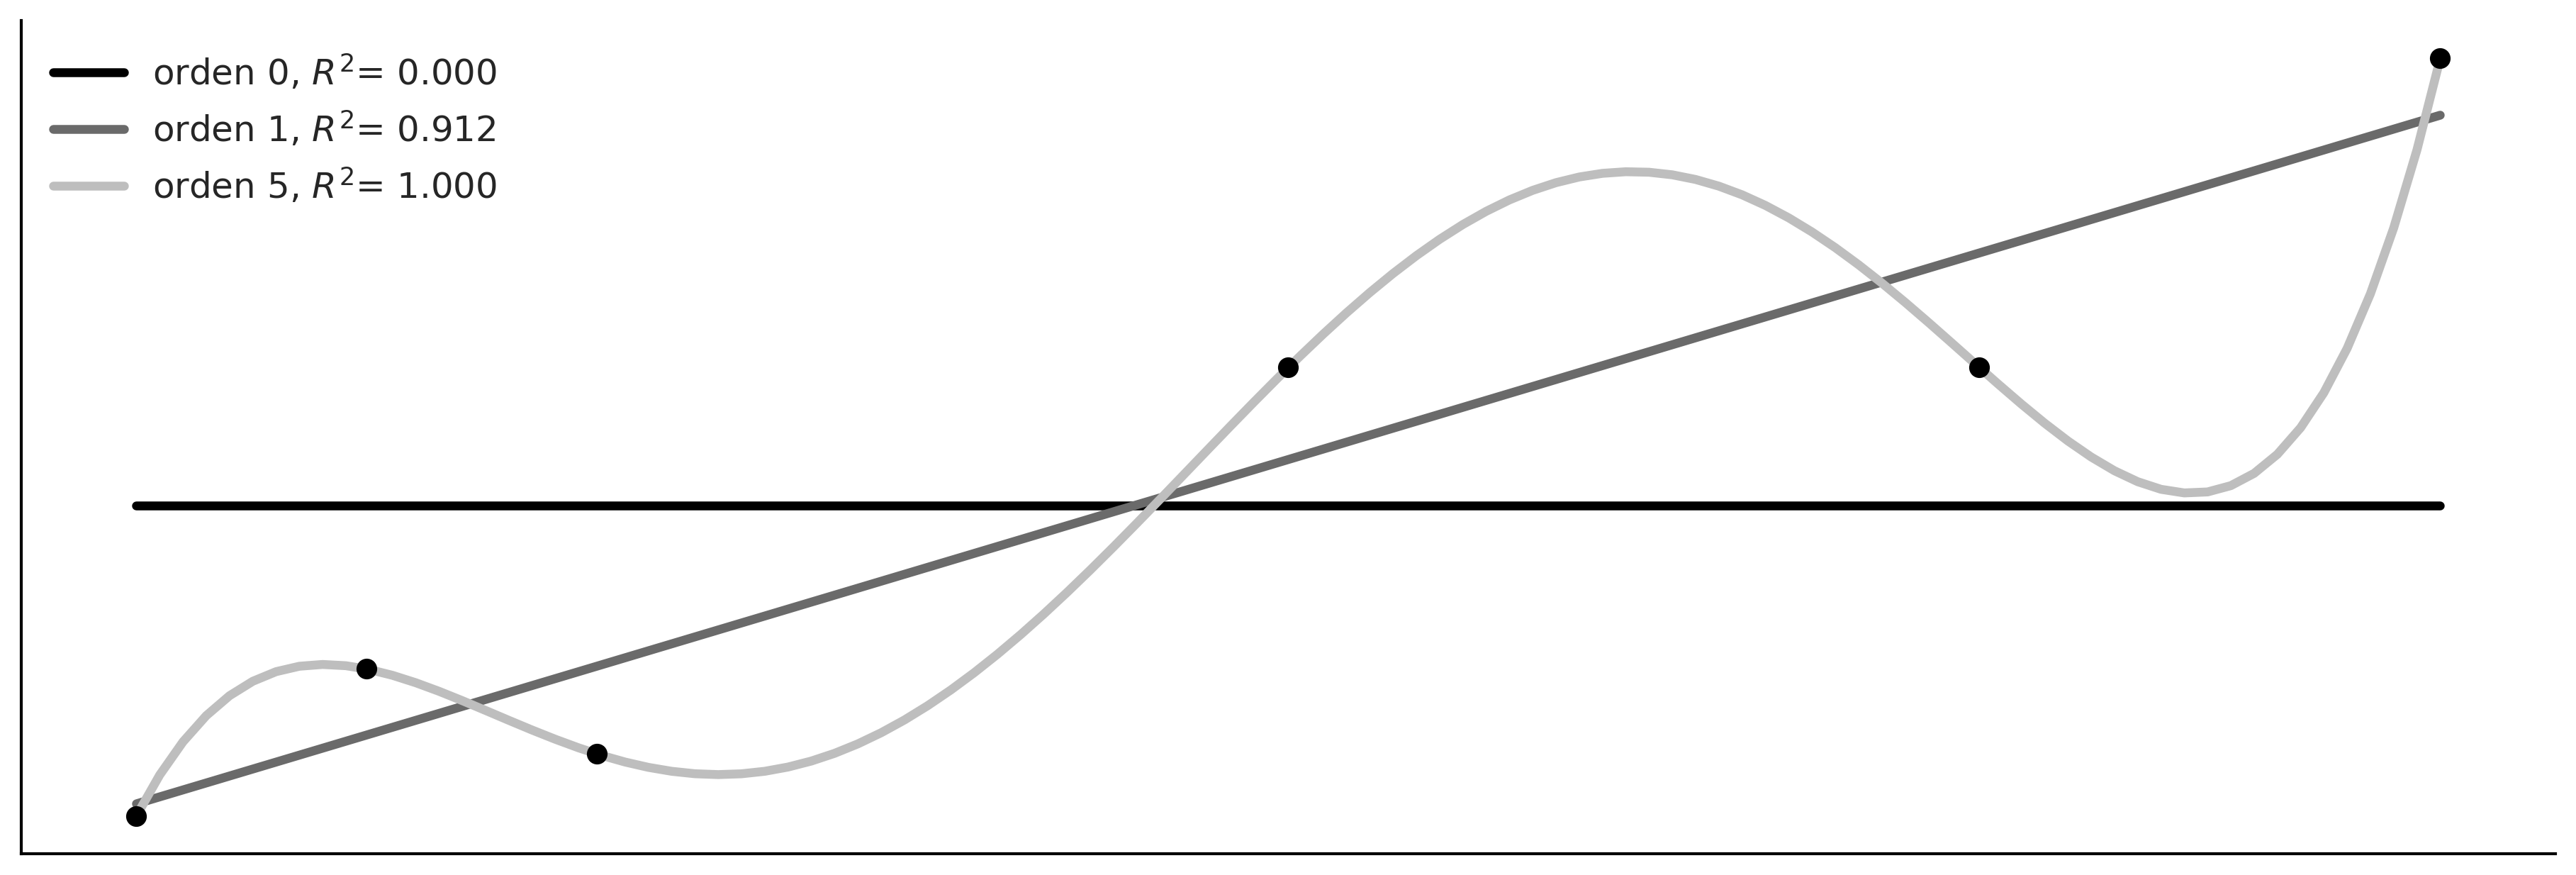

In [16]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}', lw=3)

    
ax.legend(loc=2, fontsize=12)
plt.savefig("../fig/over_under_fit.png")